## Import libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array, csr_array, csc_array
from collections import Counter
%matplotlib inline
%load_ext autoreload
%autoreload 2
import scipy
import time
from multiprocessing import Manager,Pool
import gc

In [50]:
from worker1 import matrix_helper
from worker2 import picard_helper
from gmsh_util import createMesh, read_mesh
from quasi_static_util import quasi_static_fem, quasi_static_picard

## Validation of quasi-static solver code 
### (using a variable mesh as prescribed in literature)

In [16]:
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all = 1,
                                msf_adapt=0.5,
                                side = 6,
                                x_s=50,
                                y_s=25,
                                is_adapt=True
                                )

Reading reqd_mesh.msh
Number of nodes in the mesh: 6565
Number of triangles in the mesh: 12828



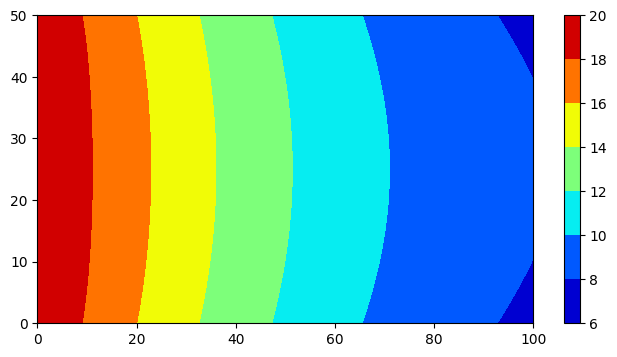

In [9]:
# No source
soln_qs = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
h,K,G,F,boundary,theta = soln_qs.fit_ele(mode = "no_source",verbose = False)
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [10]:
gc.collect()

5123

In [11]:
print(f"The maximum temperature is {np.max(theta):.2f}C and the minimum temperature is {np.min(theta):.2f} C")

The maximum temperature is 20.00C and the minimum temperature is 7.67 C


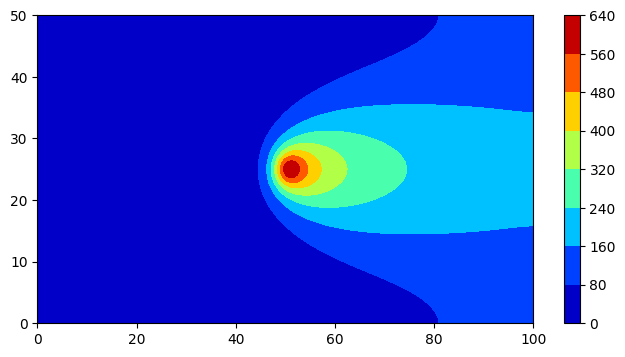

In [17]:
#Source with physical properties not being a function of temperature
soln_qs = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
_,K,G,F,boundary,theta = soln_qs.fit_ele(mode = "linear",verbose = False)
# h,K,G,F,boundary_term,theta
gc.collect()
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [18]:
gc.collect()

5190

In [19]:
print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

The maximum temperature is 631.75 K and the minimum temperature is 19.63 K


## Validation of picard iteration

In [28]:
from picard_valid_util import picard_sq, picard_iterative_sq

Reading reqd_mesh.msh
Number of nodes in the mesh: 380
Number of triangles in the mesh: 690

Error at 1 iteration at time 0 is 2.34E+02
Error at 2 iteration at time 0 is 3.52E+00
Error at 3 iteration at time 0 is 3.69E-02
Error at 4 iteration at time 0 is 2.79E-04
Error at 5 iteration at time 0 is 1.79E-06
Error at 1 iteration at time 1 is 6.46E+01
Error at 2 iteration at time 1 is 4.82E-01
Error at 3 iteration at time 1 is 2.65E-03
Error at 4 iteration at time 1 is 1.24E-05
Error at 1 iteration at time 2 is 4.52E+01
Error at 2 iteration at time 2 is 2.56E-01
Error at 3 iteration at time 2 is 1.29E-03
Error at 4 iteration at time 2 is 1.17E-05
Error at 1 iteration at time 3 is 3.69E+01
Error at 2 iteration at time 3 is 1.62E-01
Error at 3 iteration at time 3 is 9.17E-04
Error at 4 iteration at time 3 is 8.05E-06
Error at 1 iteration at time 4 is 3.23E+01
Error at 2 iteration at time 4 is 1.15E-01
Error at 3 iteration at time 4 is 6.96E-04
Error at 4 iteration at time 4 is 5.51E-06
Erro

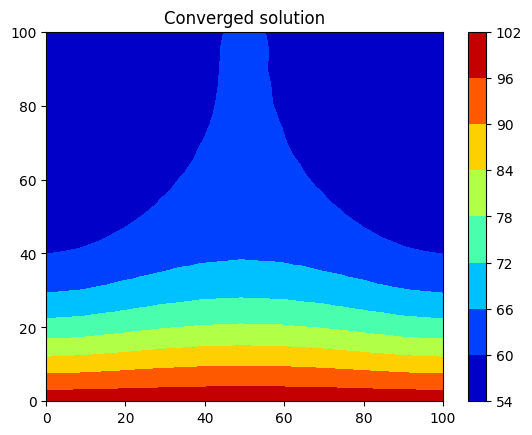

In [29]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
                                msf_all=mesh_size_factor) 
soln3 = picard_sq(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard_iterative_sq(soln3,nodecoords,ele_con,theta_init)

In [26]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

The temperature at node a is 54.74K and at node b is 54.74K


In [27]:
gc.collect()

5161

## Phase change consideration

## Transient analysis

## Adaptive meshing

### Mesh convergence

In [32]:
# Finding mesh size factor for the adaptive mesh part
mesh_size_factor = 3
area_patch = 12 * 12
area_all = 100*50
msf_patch_all = np.arange(0.1,0.2,0.01)
h_patch = []
h = []
for msf_patch in msf_patch_all:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                        msf_all=mesh_size_factor,
                                        msf_adapt=msf_patch,
                                        side = 12,
                                        x_s=50,
                                        y_s=25,
                                        is_adapt=True
                                    )
    nodes_patch = np.where((np.max(nodecoords[ele_con-1][:,:,0],axis=1)<56)*(np.min(nodecoords[ele_con-1][:,:,0],axis=1)>44)*(np.max(nodecoords[ele_con-1][:,:,1],axis=1)<31)*(np.min(nodecoords[ele_con-1][:,:,1],axis=1)>19))[0]
    h_patch.append((area_patch / len(nodes_patch))**.5)
    h.append((area_all/ len(nodecoords))**.5)

Reading reqd_mesh.msh
Number of nodes in the mesh: 61850
Number of triangles in the mesh: 123596

Reading reqd_mesh.msh
Number of nodes in the mesh: 51361
Number of triangles in the mesh: 102618

Reading reqd_mesh.msh
Number of nodes in the mesh: 43437
Number of triangles in the mesh: 86770

Reading reqd_mesh.msh
Number of nodes in the mesh: 36601
Number of triangles in the mesh: 73098

Reading reqd_mesh.msh
Number of nodes in the mesh: 31641
Number of triangles in the mesh: 63178

Reading reqd_mesh.msh
Number of nodes in the mesh: 27824
Number of triangles in the mesh: 55544

Reading reqd_mesh.msh
Number of nodes in the mesh: 24368
Number of triangles in the mesh: 48632

Reading reqd_mesh.msh
Number of nodes in the mesh: 21675
Number of triangles in the mesh: 43246

Reading reqd_mesh.msh
Number of nodes in the mesh: 19622
Number of triangles in the mesh: 39140

Reading reqd_mesh.msh
Number of nodes in the mesh: 17557
Number of triangles in the mesh: 35010



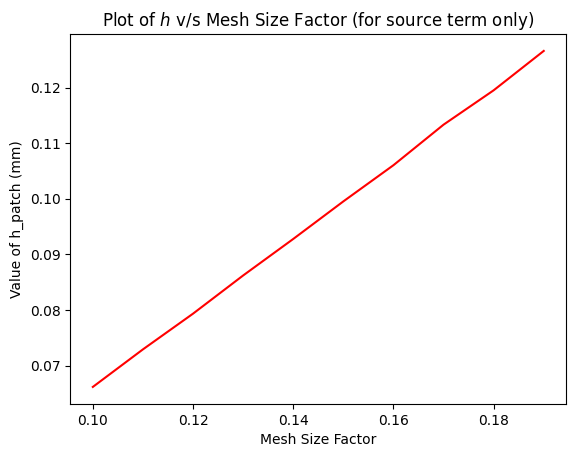

In [34]:
plt.plot(msf_patch_all,h_patch,'r')
plt.xlabel('Mesh Size Factor')
plt.ylabel('Value of h_patch (mm)')
plt.title('Plot of $h$ v/s Mesh Size Factor (for source term only)')
plt.show()

In [44]:
print(f'Value of h for mesh size factor 0.15 is '+str(h_patch[5]))

Value of h for mesh size factor 0.15 is 0.09951740497375204


In [45]:
gc.collect()

7

Reading reqd_mesh.msh
Number of nodes in the mesh: 33921
Number of triangles in the mesh: 67540

Reading reqd_mesh.msh
Number of nodes in the mesh: 25749
Number of triangles in the mesh: 51434

Reading reqd_mesh.msh
Number of nodes in the mesh: 19097
Number of triangles in the mesh: 38158

Reading reqd_mesh.msh
Number of nodes in the mesh: 19749
Number of triangles in the mesh: 39472

Reading reqd_mesh.msh
Number of nodes in the mesh: 12626
Number of triangles in the mesh: 25230

Reading reqd_mesh.msh
Number of nodes in the mesh: 10763
Number of triangles in the mesh: 21510

Reading reqd_mesh.msh
Number of nodes in the mesh: 7806
Number of triangles in the mesh: 15596

Reading reqd_mesh.msh
Number of nodes in the mesh: 14128
Number of triangles in the mesh: 28242

Reading reqd_mesh.msh
Number of nodes in the mesh: 1955
Number of triangles in the mesh: 3896

Reading reqd_mesh.msh
Number of nodes in the mesh: 7434
Number of triangles in the mesh: 14854



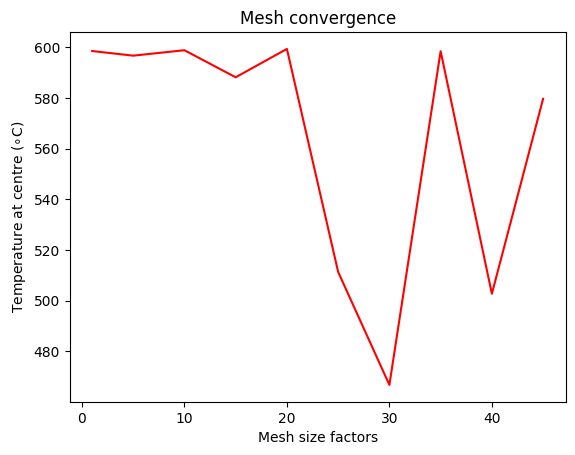

In [51]:
# mesh convergence for the coarser part given that for finer the factor is 0.15
mesh_size_factors = np.array([1]+ np.arange(5,50,5).tolist())
converged_msf_patch = 0.15

#representative point
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
n_ele = []
for mesh_size_factor in mesh_size_factors:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                        msf_all=mesh_size_factor,
                                        msf_adapt=converged_msf_patch,
                                        side = 12,
                                        x_s=50,
                                        y_s=25,
                                        is_adapt=True
                                    )
    soln_qs_p = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln_qs_p.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    n_ele.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size factors')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

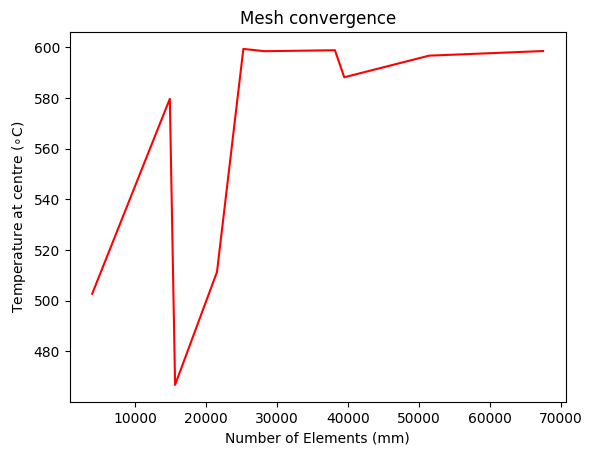

In [47]:
ele = np.argsort(n_ele)
plt.plot(np.array(n_ele)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

Slope: [-0.07730744]
Intercept: [6.56408099]


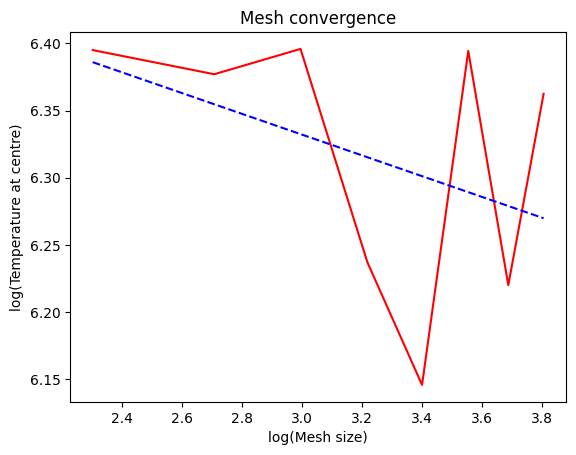

In [48]:
x = np.log(mesh_size_factors[2:])
y = np.log(T_reps[2:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

In [49]:
gc.collect()

6994

## Final solution

Reading reqd_mesh.msh
Number of nodes in the mesh: 34251
Number of triangles in the mesh: 68200

Reading reqd_mesh.msh
Number of nodes in the mesh: 34251
Number of triangles in the mesh: 68200

Time is 12.5 seconds
Error at 1 iteration is 6.39E+04
Error at 2 iteration is 5.69E+01
Error at 3 iteration is 1.76E-02
Error at 4 iteration is 5.00E-06


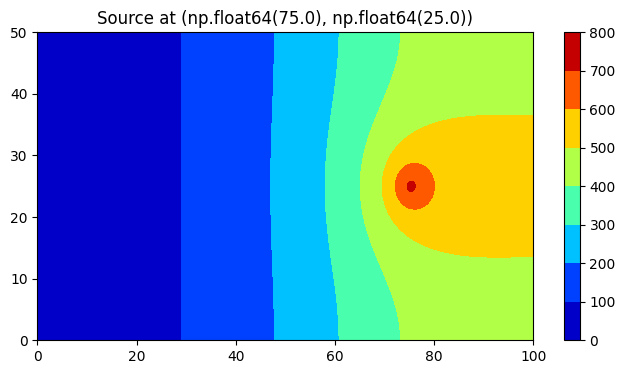

Reading reqd_mesh.msh
Number of nodes in the mesh: 33921
Number of triangles in the mesh: 67540

Reading reqd_mesh.msh
Number of nodes in the mesh: 33921
Number of triangles in the mesh: 67540

Time is 25 seconds
Error at 1 iteration is 6.94E+04
Error at 2 iteration is 8.05E+01
Error at 3 iteration is 3.01E-02
Error at 4 iteration is 8.52E-06


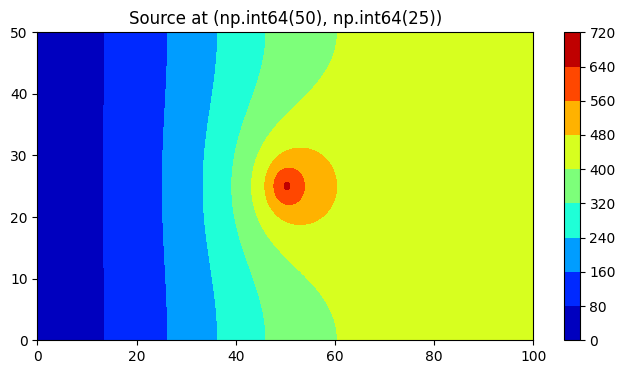

Reading reqd_mesh.msh
Number of nodes in the mesh: 34369
Number of triangles in the mesh: 68436

Reading reqd_mesh.msh
Number of nodes in the mesh: 34369
Number of triangles in the mesh: 68436

Time is 37.5 seconds
Error at 1 iteration is 9.04E+04
Error at 2 iteration is 9.23E+01
Error at 3 iteration is 4.19E-02
Error at 4 iteration is 1.22E-05


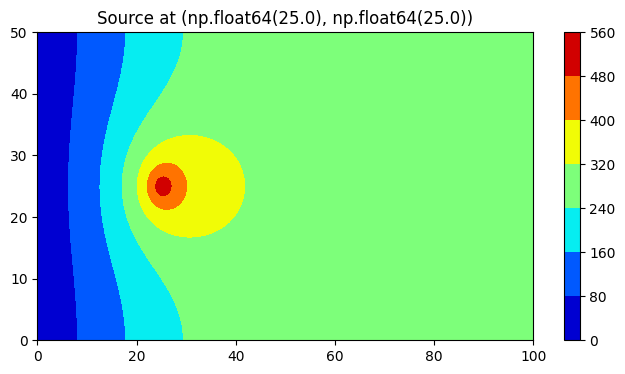

Reading reqd_mesh.msh
Number of nodes in the mesh: 20253
Number of triangles in the mesh: 40062



In [53]:
# Final solution for Titanium alloy with assumed properties and no physical modelling
T_l = 273+500
vo = 2 #mm/s
t_final = 10
times = [12.5,25,37.5]
converged_msf = 1
x_source = 100
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all=converged_msf,
                                msf_adapt=converged_msf_patch,
                                side = 12,
                                x_s=x_source-times[0]*vo,
                                y_s=25,
                                is_adapt=True)

theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
for i,t in enumerate(times):
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=converged_msf,
                                    msf_adapt=converged_msf_patch,
                                    side = 12,
                                    x_s=x_source-vo*t,
                                    y_s=25,
                                    is_adapt=True
                                )
    print(f"Time is {t} seconds")
    theta_final = quasi_static_picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source-vo*t,25]]))
    nodecoords,_ = createMesh(geo_file='rectangle.geo',
                                    msf_all=converged_msf,
                                    msf_adapt=converged_msf_patch,
                                    side = 12,
                                    x_s=x_source-vo*(times[i+1] if i+1 < len(times) else 0),
                                    y_s=25,
                                    is_adapt=True
                                )
    theta_prev = np.zeros((nodecoords.shape[0],1))+T_l

1.5
Reading reqd_mesh.msh
Number of nodes in the mesh: 787
Number of triangles in the mesh: 1470

1.6
Reading reqd_mesh.msh
Number of nodes in the mesh: 706
Number of triangles in the mesh: 1312

1.7000000000000002
Reading reqd_mesh.msh
Number of nodes in the mesh: 613
Number of triangles in the mesh: 1130

1.8000000000000003
Reading reqd_mesh.msh
Number of nodes in the mesh: 555
Number of triangles in the mesh: 1022

1.9000000000000004
Reading reqd_mesh.msh
Number of nodes in the mesh: 539
Number of triangles in the mesh: 992

3.0
Reading reqd_mesh.msh
Number of nodes in the mesh: 221
Number of triangles in the mesh: 388

4.0
Reading reqd_mesh.msh
Number of nodes in the mesh: 140
Number of triangles in the mesh: 238

5.0
Reading reqd_mesh.msh
Number of nodes in the mesh: 96
Number of triangles in the mesh: 156

6.0
Reading reqd_mesh.msh
Number of nodes in the mesh: 80
Number of triangles in the mesh: 130

7.0
Reading reqd_mesh.msh
Number of nodes in the mesh: 60
Number of triangles in

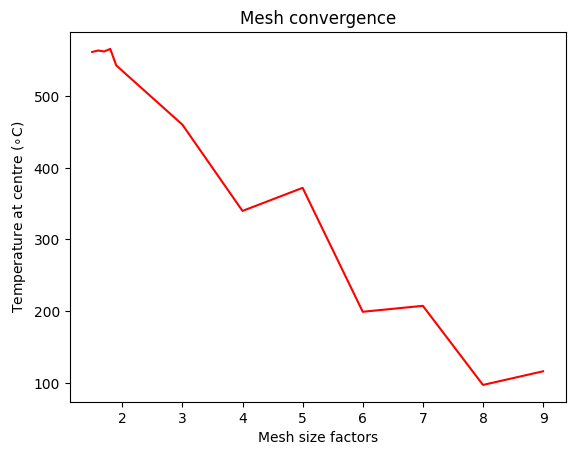

In [55]:
# Normal mesh convergence for phase change consideration of Titanium alloy

mesh_size_factors = np.array(np.arange(1.5,2,0.1).tolist() + np.arange(3,10,1).tolist())
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
n_ele = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=mesh_size_factor,
                                )
    soln1 = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    n_ele.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size factors')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

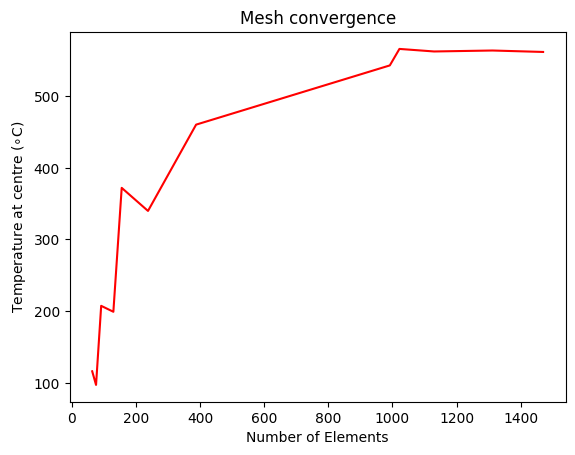

In [57]:
ele = np.argsort(n_ele)
plt.plot(np.array(n_ele)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

Slope: [-2.10676639]
Intercept: [9.23036282]


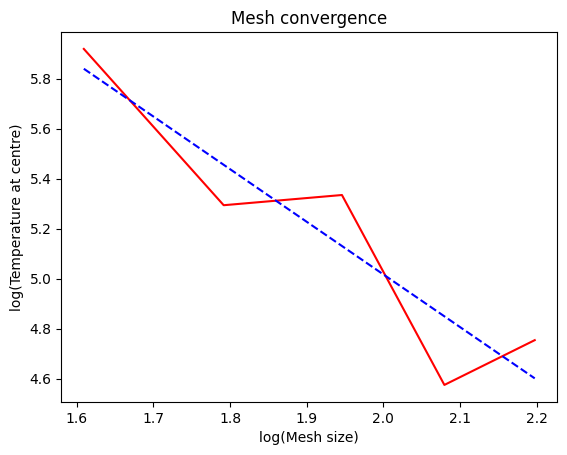

In [58]:
x = np.log(mesh_size_factors[7:])
y = np.log(T_reps[7:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 0 seconds
Error at 1 iteration is 2.83E+04
Error at 2 iteration is 1.99E+03
Error at 3 iteration is 3.90E+02
Error at 4 iteration is 7.43E+01
Error at 5 iteration is 1.32E+01
Error at 6 iteration is 2.83E+00
Error at 7 iteration is 4.73E-01
Error at 8 iteration is 1.08E-01
Error at 9 iteration is 1.69E-02
Error at 10 iteration is 4.00E-03
Error at 11 iteration is 6.03E-04
Error at 12 iteration is 1.42E-04
Error at 13 iteration is 2.18E-05


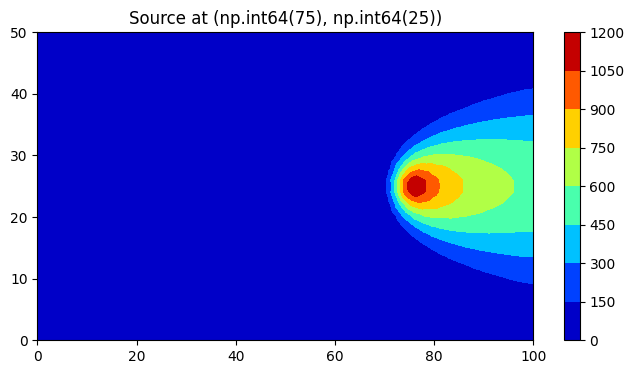

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 2 seconds
Error at 1 iteration is 3.74E+03
Error at 2 iteration is 1.96E+03
Error at 3 iteration is 3.80E+02
Error at 4 iteration is 7.30E+01
Error at 5 iteration is 1.92E+01
Error at 6 iteration is 3.08E+00
Error at 7 iteration is 8.30E-01
Error at 8 iteration is 1.27E-01
Error at 9 iteration is 3.20E-02
Error at 10 iteration is 5.09E-03
Error at 11 iteration is 1.15E-03
Error at 12 iteration is 1.99E-04
Error at 13 iteration is 3.95E-05


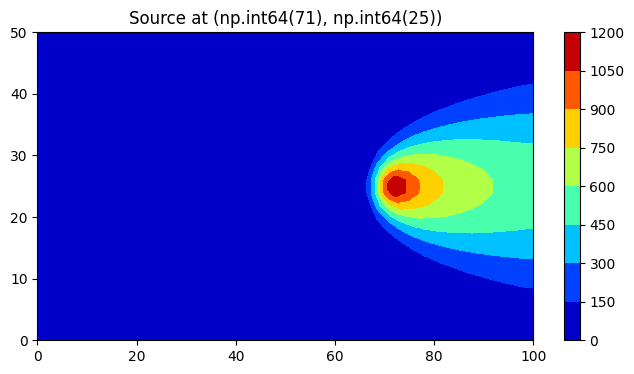

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 4 seconds
Error at 1 iteration is 3.70E+03
Error at 2 iteration is 2.00E+03
Error at 3 iteration is 3.99E+02
Error at 4 iteration is 7.59E+01
Error at 5 iteration is 2.02E+01
Error at 6 iteration is 3.21E+00
Error at 7 iteration is 8.71E-01
Error at 8 iteration is 1.32E-01
Error at 9 iteration is 3.32E-02
Error at 10 iteration is 5.26E-03
Error at 11 iteration is 1.18E-03
Error at 12 iteration is 2.03E-04
Error at 13 iteration is 4.03E-05


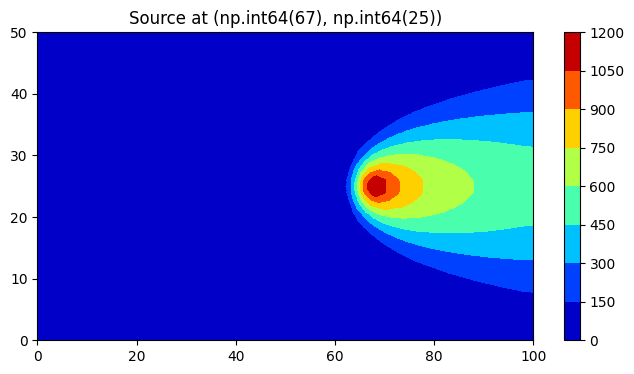

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 6 seconds
Error at 1 iteration is 3.76E+03
Error at 2 iteration is 2.05E+03
Error at 3 iteration is 4.12E+02
Error at 4 iteration is 7.83E+01
Error at 5 iteration is 2.08E+01
Error at 6 iteration is 3.26E+00
Error at 7 iteration is 8.84E-01
Error at 8 iteration is 1.31E-01
Error at 9 iteration is 3.31E-02
Error at 10 iteration is 5.04E-03
Error at 11 iteration is 1.16E-03
Error at 12 iteration is 1.87E-04
Error at 13 iteration is 3.88E-05


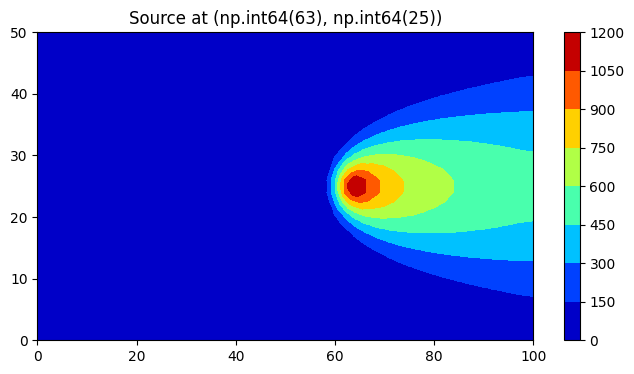

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 8 seconds
Error at 1 iteration is 3.79E+03
Error at 2 iteration is 2.10E+03
Error at 3 iteration is 4.30E+02
Error at 4 iteration is 8.17E+01
Error at 5 iteration is 2.20E+01
Error at 6 iteration is 3.42E+00
Error at 7 iteration is 9.43E-01
Error at 8 iteration is 1.39E-01
Error at 9 iteration is 3.55E-02
Error at 10 iteration is 5.44E-03
Error at 11 iteration is 1.24E-03
Error at 12 iteration is 2.04E-04
Error at 13 iteration is 4.17E-05


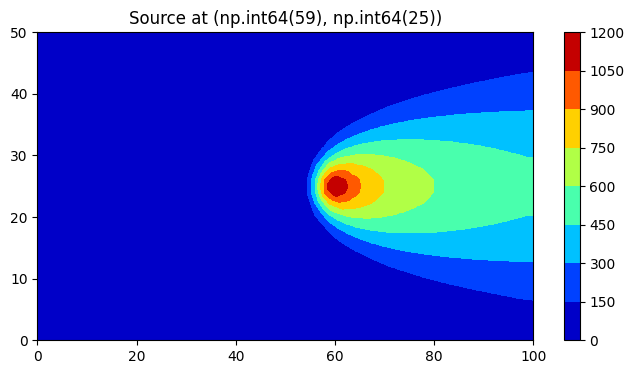

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 10 seconds
Error at 1 iteration is 3.83E+03
Error at 2 iteration is 2.13E+03
Error at 3 iteration is 4.46E+02
Error at 4 iteration is 8.35E+01
Error at 5 iteration is 2.30E+01
Error at 6 iteration is 3.51E+00
Error at 7 iteration is 9.91E-01
Error at 8 iteration is 1.46E-01
Error at 9 iteration is 3.74E-02
Error at 10 iteration is 5.81E-03
Error at 11 iteration is 1.31E-03
Error at 12 iteration is 2.22E-04
Error at 13 iteration is 4.45E-05


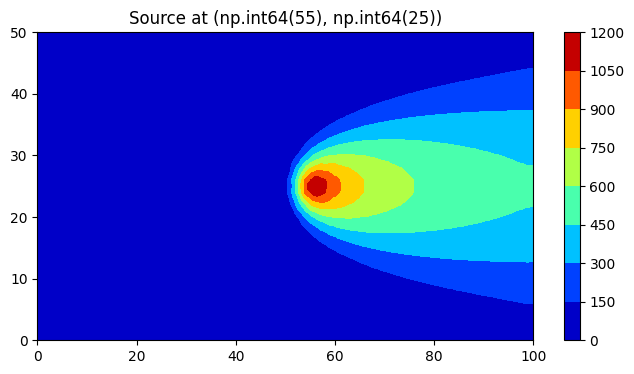

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 12 seconds
Error at 1 iteration is 3.90E+03
Error at 2 iteration is 2.16E+03
Error at 3 iteration is 4.62E+02
Error at 4 iteration is 8.52E+01
Error at 5 iteration is 2.40E+01
Error at 6 iteration is 3.61E+00
Error at 7 iteration is 1.04E+00
Error at 8 iteration is 1.52E-01
Error at 9 iteration is 3.90E-02
Error at 10 iteration is 6.12E-03
Error at 11 iteration is 1.36E-03
Error at 12 iteration is 2.35E-04
Error at 13 iteration is 4.59E-05


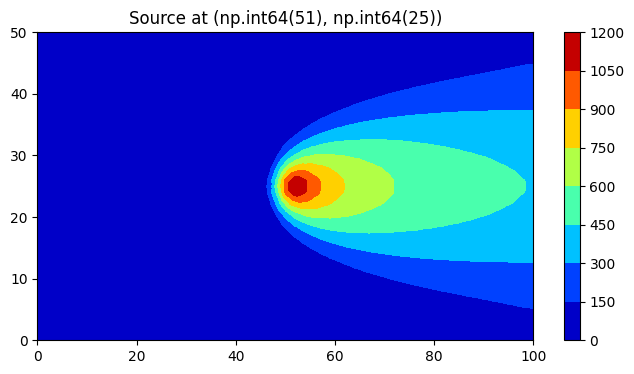

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 14 seconds
Error at 1 iteration is 3.84E+03
Error at 2 iteration is 2.20E+03
Error at 3 iteration is 4.77E+02
Error at 4 iteration is 8.78E+01
Error at 5 iteration is 2.49E+01
Error at 6 iteration is 3.70E+00
Error at 7 iteration is 1.07E+00
Error at 8 iteration is 1.55E-01
Error at 9 iteration is 4.00E-02
Error at 10 iteration is 6.22E-03
Error at 11 iteration is 1.39E-03
Error at 12 iteration is 2.38E-04
Error at 13 iteration is 4.61E-05


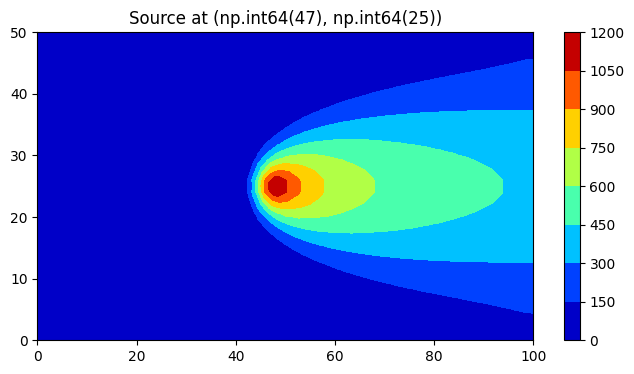

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 16 seconds
Error at 1 iteration is 3.85E+03
Error at 2 iteration is 2.21E+03
Error at 3 iteration is 4.91E+02
Error at 4 iteration is 8.97E+01
Error at 5 iteration is 2.56E+01
Error at 6 iteration is 3.77E+00
Error at 7 iteration is 1.10E+00
Error at 8 iteration is 1.58E-01
Error at 9 iteration is 4.08E-02
Error at 10 iteration is 6.34E-03
Error at 11 iteration is 1.40E-03
Error at 12 iteration is 2.41E-04
Error at 13 iteration is 4.59E-05


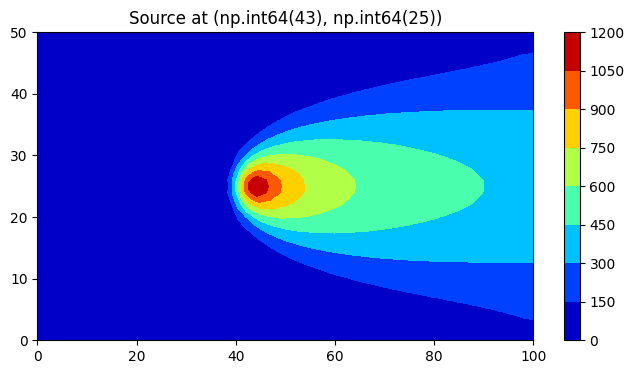

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 18 seconds
Error at 1 iteration is 3.92E+03
Error at 2 iteration is 2.24E+03
Error at 3 iteration is 5.05E+02
Error at 4 iteration is 9.12E+01
Error at 5 iteration is 2.63E+01
Error at 6 iteration is 3.83E+00
Error at 7 iteration is 1.13E+00
Error at 8 iteration is 1.61E-01
Error at 9 iteration is 4.18E-02
Error at 10 iteration is 6.50E-03
Error at 11 iteration is 1.42E-03
Error at 12 iteration is 2.48E-04
Error at 13 iteration is 4.66E-05


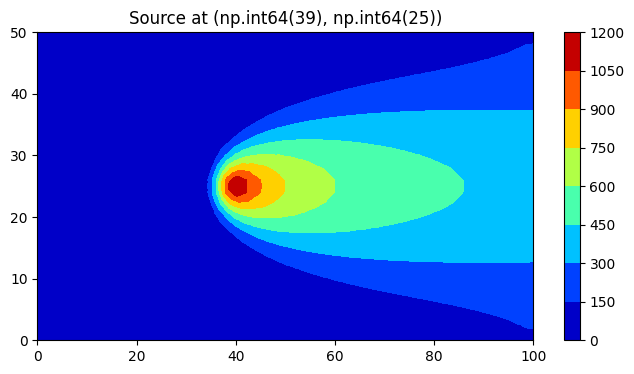

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 20 seconds
Error at 1 iteration is 3.92E+03
Error at 2 iteration is 2.27E+03
Error at 3 iteration is 5.17E+02
Error at 4 iteration is 9.35E+01
Error at 5 iteration is 2.71E+01
Error at 6 iteration is 3.95E+00
Error at 7 iteration is 1.17E+00
Error at 8 iteration is 1.69E-01
Error at 9 iteration is 4.40E-02
Error at 10 iteration is 6.98E-03
Error at 11 iteration is 1.52E-03
Error at 12 iteration is 2.74E-04
Error at 13 iteration is 5.09E-05


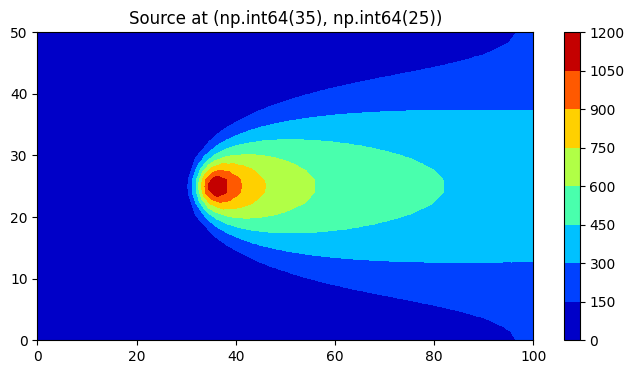

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 22 seconds
Error at 1 iteration is 3.98E+03
Error at 2 iteration is 2.30E+03
Error at 3 iteration is 5.33E+02
Error at 4 iteration is 9.53E+01
Error at 5 iteration is 2.79E+01
Error at 6 iteration is 4.07E+00
Error at 7 iteration is 1.21E+00
Error at 8 iteration is 1.76E-01
Error at 9 iteration is 4.57E-02
Error at 10 iteration is 7.36E-03
Error at 11 iteration is 1.59E-03
Error at 12 iteration is 2.92E-04
Error at 13 iteration is 5.33E-05


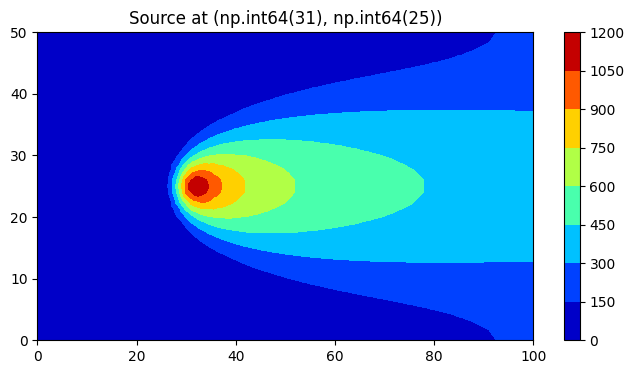

Reading reqd_mesh.msh
Number of nodes in the mesh: 1596
Number of triangles in the mesh: 3040

Time is 24 seconds
Error at 1 iteration is 4.03E+03
Error at 2 iteration is 2.32E+03
Error at 3 iteration is 5.45E+02
Error at 4 iteration is 9.67E+01
Error at 5 iteration is 2.84E+01
Error at 6 iteration is 4.12E+00
Error at 7 iteration is 1.22E+00
Error at 8 iteration is 1.76E-01
Error at 9 iteration is 4.56E-02
Error at 10 iteration is 7.26E-03
Error at 11 iteration is 1.56E-03
Error at 12 iteration is 2.83E-04
Error at 13 iteration is 5.12E-05


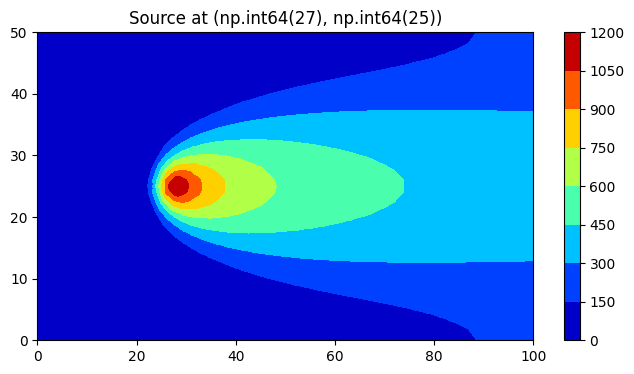

In [60]:
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all=1
                                )
T_l = 273+500
vo = 2 #mm/s
t_final = 25
times = np.arange(0,t_final,2)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 75
for t in times:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=1
                                )
    print(f"Time is {t} seconds")
    theta_final = quasi_static_picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source-vo*t,25]]),mode="phase_change")
    theta_prev = theta_final